<a href="https://colab.research.google.com/github/Ptchangai/DataScience/blob/main/TSA_ActivityClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time series classification

We have time series corresponding to different physical activities.
The goal is to create a model and train it to classify the time series according to the matching activity. We will export the model to be used in Unity, with Barracuda.

We use data from the  WISDM Lab, that collects sensor data from mobile device to work on activity recognition. The activities include walking, jogging, sitting, going upstairs and downstars,  and standing.

# Nytt avsnitt

##Tools

In [ ]:
#Helper libraries
import pandas as pd
import numpy as np
#Statistical data visualization library:
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


In [ ]:

#load data
!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
!tar -xvf WISDM_ar_latest.tar.gz

!pip install gdown
!pip install tensorflow-gpu

!pip install git+https://github.com/onnx/tensorflow-onnx


Downloading...
From: https://drive.google.com/uc?id=152sWECukjvLerrVG2NUO8gtMFg83RKCF
To: /content/WISDM_ar_latest.tar.gz
11.4MB [00:00, 100MB/s]
WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt
     |████████████████████████████████| 320.4MB 54kB/s 


  Cloning https://github.com/onnx/tensorflow-onnx to /tmp/pip-req-build-d99ox05d
  Running command git clone -q https://github.com/onnx/tensorflow-onnx /tmp/pip-req-build-d99ox05d
     |████████████████████████████████| 7.7MB 4.0MB/s 
  Created wheel for tf2onnx: filename=tf2onnx-1.8.0-cp36-none-any.whl size=203988 sha256=6de2f7a6042b6b8555f1c03e600e55ac5d10c5002a258ad1781574bbac1c3af0
  Stored in directory: /tmp/pip-ephem-wheel-cache-e7i456nv/wheels/db/db/21/74f30455028095a1ee011391af71fb68fde8660aad68602f2a
Successfully built tf2onnx


#Prepare the data

We add names and remove errors (z axis data are followed by ;)

In [ ]:
#add names
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)

#remove extra ; after column
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
#remove missing values
df.dropna(axis=0, how='any', inplace=True)

##Examine the data
We look into the data.

In [ ]:
#Peek into the data
print(df.shape)
df.head()

(1098203, 6)


,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


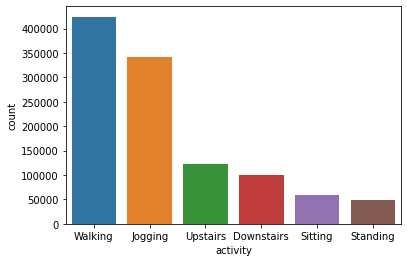

In [ ]:
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);

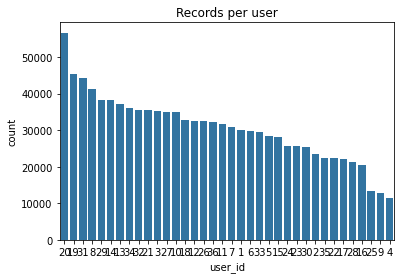

In [ ]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

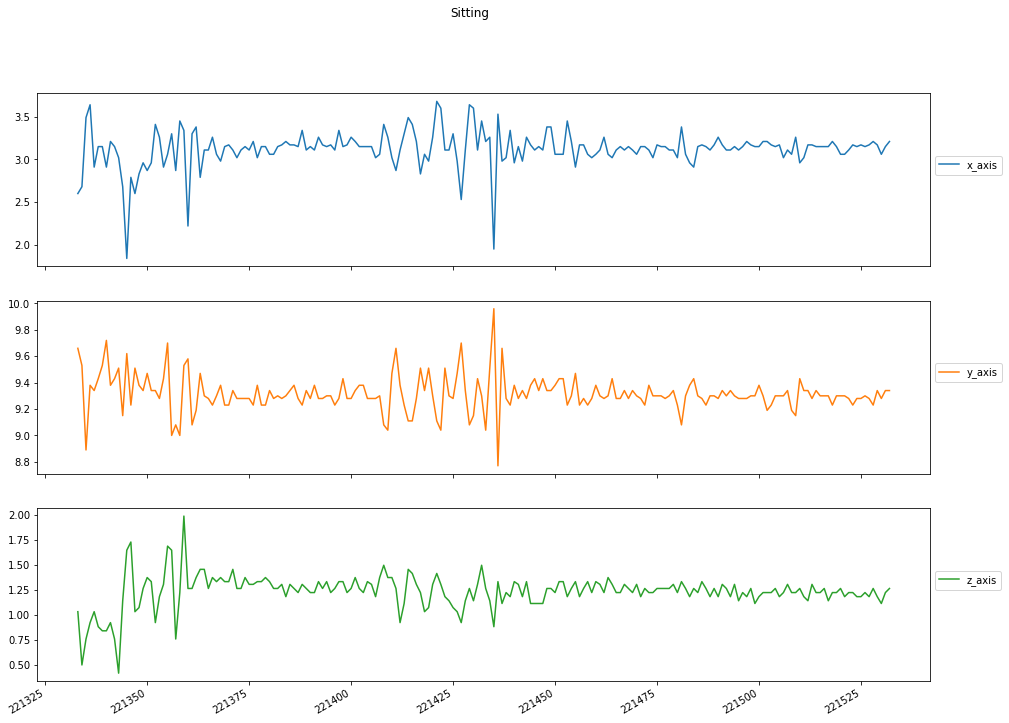

In [ ]:
#plot activity 

def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

plot_activity("Sitting", df);

##Preprocessing
Now we need to preprocess the data. We split it into a training (30st) and a test set for later.

In [ ]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [ ]:
#scale the data
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [ ]:
#create dataset. We create the sequences by modifying the usual create_dataset function:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values #select columns
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

#TIME_STEPS = 200
TIME_STEPS = 3 #combien de temps dure chaque séquence ?
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [ ]:
df_test.dtypes

user_id        int64
activity      object
timestamp      int64
x_axis       float64
y_axis       float64
z_axis       float64
dtype: object

In [ ]:
import sklearn

In [ ]:
#last preprocessing step, we encode the categories. pd.replace did not seem to work.

enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)

y_test = enc.transform(y_test)

#Classification

##Model 1

In [ ]:
#We need to build a LSTM Model for classification

import tensorflow as tf
from tensorflow import keras

#Develop the Model. "This is a simple Bidirectional LSTM model" 
#!! Changer la mise en place du modèle
#!! toucher à Bidirectional
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=128, activation='relu')) #1+
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

#we compile with categorical crossentropy because it is a multi-class classification problem
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [ ]:
#train the model. NO SHUFFLE
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)

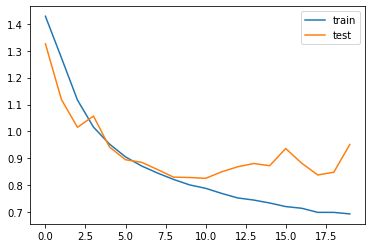

In [ ]:
#check value loss to evaluate the model
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:

model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)


157/157 [==============================] - 1s 4ms/step - loss: 0.8726 - acc: 0.6849


In [ ]:
Prediction=enc.inverse_transform(y_pred)
Test=enc.inverse_transform(y_test)

sum(Prediction==Test)/len(Test)

array([0.68494796])

In [ ]:
model.save('/content/')

INFO:tensorflow:Assets written to: /content/assets


In [ ]:
!pip install git+https://github.com/onnx/tensorflow-onnx


In [ ]:
!python -m tf2onnx.convert --saved-model /content/ --output model.onnx
#!python -m tf2onnx.convert --graphdef /content/saved_model --inputs=input:0 --outputs=output:0 --output model.onnx

##Model 2

In [ ]:
#We need to build a LSTM Model for classification
#Develop the Model. "This is a simple Bidirectional LSTM model" 
model2 = keras.Sequential()
#model2.add(keras.layers.Dropout(rate=0.5))
model2.add(keras.layers.Dense(units=128, activation='relu'))
model2.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               135168    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 185,350
Trainable params: 185,350
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2 = keras.Sequential()
model2.add(
      keras.layers.LSTM(units=128, input_shape=[5, 3])
    )
model2.add(keras.layers.Dropout(rate=0.5))
model2.add(keras.layers.Dense(units=128, activation='relu')) #1+
model2.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

#we compile with categorical crossentropy because it is a multi-class classification problem
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total params: 84,870
Trainable params: 84,870
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])


In [ ]:
#train the model. NO SHUFFLE
history = model2.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)
Prediction=enc.inverse_transform(y_pred)
Test=enc.inverse_transform(y_test)

sum(Prediction==Test)/len(Test)


Epoch 1/10
316/316 [==============================] - 4s 13ms/step - loss: 1.4203 - acc: 0.5012 - val_loss: 1.1835 - val_acc: 0.5957
Epoch 2/10
316/316 [==============================] - 4s 12ms/step - loss: 1.2736 - acc: 0.5320 - val_loss: 1.1356 - val_acc: 0.6193
Epoch 3/10
316/316 [==============================] - 4s 11ms/step - loss: 1.1954 - acc: 0.5634 - val_loss: 1.0470 - val_acc: 0.6598
Epoch 4/10
316/316 [==============================] - 4s 11ms/step - loss: 1.0790 - acc: 0.6219 - val_loss: 0.9760 - val_acc: 0.6670
Epoch 5/10
316/316 [==============================] - 4s 11ms/step - loss: 1.0172 - acc: 0.6410 - val_loss: 0.9550 - val_acc: 0.6745
Epoch 6/10
316/316 [==============================] - 4s 11ms/step - loss: 0.9798 - acc: 0.6550 - val_loss: 0.9468 - val_acc: 0.6776
Epoch 7/10
316/316 [==============================] - 4s 11ms/step - loss: 0.9472 - acc: 0.6698 - val_loss: 0.9185 - val_acc: 0.6963
Epoch 8/10
316/316 [==============================] - 4s 11ms/step - 

array([0.67433947])

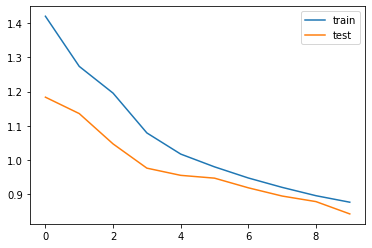

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
model2.evaluate(X_test, y_test)
y_pred = model2.predict(X_test)
model2.save('/content/3/')

157/157 [==============================] - 1s 3ms/step - loss: 0.9613 - acc: 0.6717
INFO:tensorflow:Assets written to: /content/3/assets


In [ ]:
!pip install git+https://github.com/onnx/tensorflow-onnx
!python -m tf2onnx.convert --saved-model /content/3/ --output model.onnx

##Model 3

In [ ]:
#Reshape train array
X_trainM3=[]
[ X_trainM3.append(Xi.reshape(1,9)[0]) for Xi in X_train ]
print(X_trainM3[1]) #vector of 9 values


[0.13613874 0.10059377 0.46581909 0.14686343 0.02229717 0.48235709
 0.26126005 0.10548731 0.61466072]


In [ ]:
Y_trainM3=[]
[Y_trainM3.append(Yi.argmax()) for Yi in y_train]
print(Y_trainM3[1])

5


In [ ]:
#Turn into dataframe

df3= pd.DataFrame(X_trainM3)
df3['category']=Y_trainM3
df3.head()

,0,1,2,3,4,5,6,7,8,category
0,0.019955,0.252293,-0.090959,-0.055118,0.297966,-0.099228,-0.085505,0.257187,-0.124035,5
1,0.136139,0.100594,0.465819,0.146863,0.022297,0.482357,0.261260,0.105487,0.614661,5
2,0.211212,0.771009,-0.005513,0.261260,-0.147346,-0.501651,-0.160577,0.059814,0.024807,5
3,-0.069418,0.614415,0.901319,-0.226713,-0.073942,0.016538,0.316671,0.335484,0.000000,5
4,0.191550,0.753066,-0.223262,0.307734,0.146267,-0.441012,0.175463,-0.210961,-0.286658,5


In [ ]:




X=df.iloc[:, 0:2]/2
y=df.classe

#!pip install tf-nightly
import tensorflow as tf
from tensorflow import keras

model5 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2)
])

#model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model5.compile(optimizer='sgd', loss=tf.keras.losses.BinaryCrossentropy() )


history = model5.fit(X, y, epochs=100,batch_size=64,validation_split=0.1, shuffle=False)

model5.summary()



In [ ]:
model3 = keras.Sequential()
#model3.add(keras.layers.InputLayer(input_shape=(9,)))
model3.add(keras.layers.Dense(units=128, input_shape=[9,], activation='relu'))
#model3.add(keras.layers.Dropout(rate=0.5))
model3.add(keras.layers.Dense(units=128, activation='relu')) #1+
#model3.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model3.add(keras.layers.Dense(y_train.shape[1], activation='softmax')) #6 values

#we compile with categorical crossentropy because it is a multi-class classification problem
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model3.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_47 (Dense)             (None, 6)                 774       
Total params: 2,054
Trainable params: 2,054
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model3.fit(
    X_trainM3, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.3,
    shuffle=True
)


#Basic Model

In [ ]:
#Create the data : 2 classes (1,0). 2dim data (x,y). 
import pandas as pd
import h5py

#Train=[[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1],[2,2,1]]
Train=[[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[1,1,0],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2]]

df= pd.DataFrame(Train, columns=['x','y','classe'])


X=df.iloc[:, 0:2]/2
y=df.classe
df.head()

,x,y,classe
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,1,1,0


In [ ]:
#Create the model

#!pip install tf-nightly
import tensorflow as tf
from tensorflow import keras

model5 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2)
])

#model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model5.compile(optimizer='sgd', loss=tf.keras.losses.BinaryCrossentropy() )

model5.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 22        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model5.fit(X, y, epochs=100,batch_size=5,validation_split=0.1, shuffle=False)

Epoch 1/100
5/5 [==============================] - 0s 31ms/step - loss: 1.0660 - val_loss: -0.6379
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: -1.2244 - val_loss: -15.2492
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: -7.0449 - val_loss: -15.2492
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: -3.2192 - val_loss: -15.2492
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: -1.9890 - val_loss: -15.2492
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: -1.9890 - val_loss: -15.2492
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: -1.9890 - val_loss: -15.2492
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: -1.9890 - val_loss: -15.2492
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: -1.9890 - val_loss: -15.2492
Epoch 10/100
5/5 [==============================] - 0s 6ms/step - loss: -1.9890 - val_loss: -15.2492


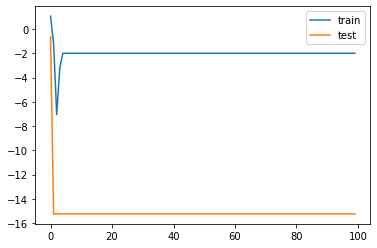

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();


In [ ]:
#error1b : this is a disfunctional code.

#xtest=X.iloc[0]
#xtest2=[[1,1],[]]
#xtest2 = [i/2 for i in xtest2]
#model.evaluate(X_test, y_test)
#ypred = model5.predict(xtest)
#ypred


In [ ]:
#Test on a single value:
Test=[[1,1,0]]
#We must turn it into a dataframe (error 1b).
dft= pd.DataFrame(Test, columns=['x','y','classe'])
y=dft.classe
Xt=dft.iloc[:, 0:2]/2

#predict
ypred = model5.predict(Xt)
ypred

array([[19.323631,  1.769122]], dtype=float32)

In [ ]:
#Modify the output to get probabilities
probability_model = tf.keras.Sequential([model5, 
                                         tf.keras.layers.Softmax()])
probability_model.predict(Xt)

array([[1.000000e+00, 2.377788e-08]], dtype=float32)

In [ ]:
#Export the model
!python -m tf2onnx.convert --saved-model /content/2/ --output modelb.onnx

/usr/bin/python3: Error while finding module specification for 'tf2onnx.convert' (ModuleNotFoundError: No module named 'tf2onnx')


In [ ]:
#export probability model
probability_model.save('/content/2/')
!python -m tf2onnx.convert --saved-model /content/2/ --output modelb2.onnx

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/2/assets
/usr/bin/python3: Error while finding module specification for 'tf2onnx.convert' (ModuleNotFoundError: No module named 'tf2onnx')


In [ ]:
df= pd.DataFrame(Train, columns=['x','y','classe'])


X=df.iloc[:, 0:2]/2
y=df.classe